Found 1153 images belonging to 2 classes.
Found 287 images belonging to 2 classes.
Epoch 1/30
73/73 [==============================] - 944s 11s/step - loss: 0.6773 - accuracy: 0.6062 - val_loss: 0.7075 - val_accuracy: 0.6132
Epoch 2/30
73/73 [==============================] - 537s 7s/step - loss: 0.5159 - accuracy: 0.7467 - val_loss: 0.9100 - val_accuracy: 0.6202
Epoch 3/30
73/73 [==============================] - 517s 7s/step - loss: 0.2830 - accuracy: 0.8899 - val_loss: 0.7568 - val_accuracy: 0.6167
Epoch 4/30
73/73 [==============================] - 514s 7s/step - loss: 0.1966 - accuracy: 0.9289 - val_loss: 0.7644 - val_accuracy: 0.6655
Epoch 5/30
73/73 [==============================] - 522s 7s/step - loss: 0.1926 - accuracy: 0.9202 - val_loss: 1.1132 - val_accuracy: 0.5679
Epoch 6/30
73/73 [==============================] - 565s 8s/step - loss: 0.1470 - accuracy: 0.9454 - val_loss: 0.7584 - val_accuracy: 0.7003
Epoch 7/30
73/73 [==============================] - 560s 8s/step - los

C:\Users\KIIT\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully at: hybrid_googleNet_xception_model.h5


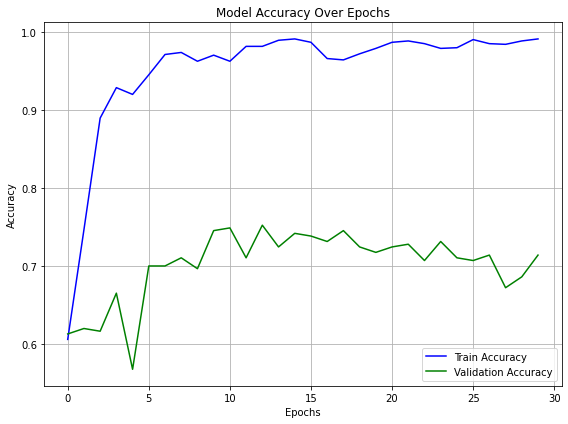

18/18 [==============================] - 25s 1s/step
Accuracy: 0.7143
Precision: 0.7320
Recall (Sensitivity): 0.8256
F1 Score: 0.7760
AUC-ROC: 0.7651
Specificity: 0.5478
K-score: 0.7143


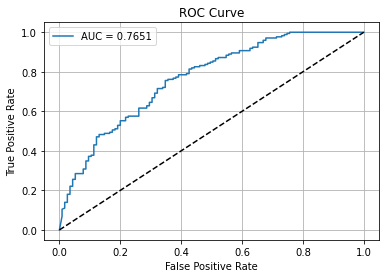

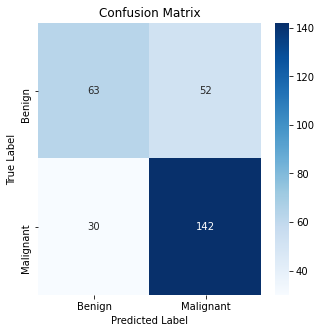

In [1]:
import os
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Image size and batch
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 30

# Dataset path
dataset_path = 'augmented_images'  # Ensure it contains /benign and /malignant folders

# Data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Input layer
input_layer = Input(shape=(224, 224, 3))

# Xception Model
xception_base = Xception(weights='imagenet', include_top=False, input_tensor=input_layer)
xception_output = GlobalAveragePooling2D()(xception_base.output)

# GoogleNet (InceptionV3)
googlenet_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_layer)
googlenet_output = GlobalAveragePooling2D()(googlenet_base.output)

# Concatenate outputs
combined_features = Concatenate()([xception_output, googlenet_output])

# Fully connected layers
fc1 = Dense(256, activation='relu')(combined_features)
fc1 = Dropout(0.5)(fc1)
output = Dense(1, activation='sigmoid')(fc1)

# Final Model
hybrid_model = Model(inputs=input_layer, outputs=output)

# Compile Model
hybrid_model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Train Model
history = hybrid_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

# Save the Model
model_save_path = "hybrid_googleNet_xception_model.h5"
hybrid_model.save(model_save_path)
print(f"Model saved successfully at: {model_save_path}")

# Plot Accuracy Graph
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Get Predictions
y_true = val_generator.classes
y_pred_prob = hybrid_model.predict(val_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Compute Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)  # Sensitivity
f1 = f1_score(y_true, y_pred)
auc_roc = roc_auc_score(y_true, y_pred_prob)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp)
k_score = (tp + tn) / (tp + tn + fp + fn)  # Kappa Score approximation

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"K-score: {k_score:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
